In [235]:
import pandas as pd
import datetime
import re
import sys
import json
from IPython.display import Image

In [236]:
item_profiles1 = pd.read_csv("item-profiles1.csv", sep=";")
item_profiles2 = pd.read_csv("item-profiles2.csv", sep=';')
item_profiles3 = pd.read_csv("item-profiles3.csv", sep=';')

In [237]:
ingredient_hashmap = {}

id = []
ingredient_count = []
weight = []

ingredients = {}

for index, row in item_profiles3.iterrows():
  recipeID = row['Recipe ID']
  newIngredients = {
        'ingredient_id':row['Ingredient ID'],
        'amount':row['Amount (g)'],
        'quantity': row['Quantity'],
        'label': row['Ingredient']
        }

  if ingredient_hashmap.get(recipeID) == None:
    ingredient_hashmap[recipeID] = [newIngredients]
    ingredients[recipeID] = [row['Ingredient']]
  else:
    ingredient_hashmap[recipeID] += [newIngredients]
    ingredients[recipeID] += [row['Ingredient']]

In [238]:
def Convert(string, delimiter):
    li = list(string.split(delimiter))
    for index in range (0, len(li)):
      li[index] = li[index].strip()
    return li

tags = []
mainTag = []
directions = []
directionCount = []
for index, row in item_profiles1.iterrows():
  categoryList = Convert(row['Category'].replace('\xa0',''), ">") # Create
  tags.append(categoryList)
  mainTag += categoryList[-1:]

  directionList = Convert(row['Directions'], "<br>")
  directions.append(directionList)
  directionCount.append(len(directionList))

item_profiles1 = item_profiles1.assign(All_Tags = tags, Main_Tag = mainTag, Direction_List = directions, Number_of_Directions = directionCount )

In [239]:
item_profiles_master = pd.merge(item_profiles1, item_profiles2, on='Recipe ID')

ingredients = []
numberOfIngredients = []
for index, row in item_profiles_master.iterrows():
  recipeID = row['Recipe ID']
  ingredients.append(ingredient_hashmap.get(recipeID))
  numberOfIngredients.append(len(ingredient_hashmap.get(recipeID)))

item_profiles_master = item_profiles_master.assign(Ingredients_map = ingredients, Number_of_Ingredients = numberOfIngredients)

#remove unecessary columns
item_profiles_master.drop(['Category', 'Directions'], inplace=True, axis=1)

pd.set_option('display.max_columns', None) # lets us see all columns when using head()

In [240]:
item_ratings = pd.read_csv("user-item-rating.csv", sep = "\t")
item_ratings.columns= ["User ID", "Item ID", "User Rating"]


In [241]:
ipm = item_profiles_master.copy()

In [242]:
today = datetime.date.today()
year = today.year

bookmarks_per_year = []

for idx, row in ipm.iterrows():
  recipe_age = int(year) - int(row["Year of Publishing"])
  bookmarks_per_year.append(row["Number of Bookmarks"] / recipe_age)

In [243]:
def definePer100g(dataframe):

    carbs_per_100g = []
    protein_per_100g = []
    kcal_per_100g = []

    for idx, row in dataframe.iterrows():
        carbs_per_100g.append(    float( '%.2f'  %   (((row["Carbohydrates (g)"]*row["Servings"]) / row["Size (g)"])*100)))
        protein_per_100g.append(  float( '%.2f'  %   (((row["Protein (g)"]*row["Servings"])       / row["Size (g)"])*100)))
        kcal_per_100g.append(     float( '%.2f'  %   (((row["Calories (kCal)"]*row["Servings"])   / row["Size (g)"])*100)))
        

    dataframe['carbohydrates_per_100g'] = carbs_per_100g
    dataframe['protein_per_100g'] = protein_per_100g
    dataframe['kcal_per_100g'] = kcal_per_100g

In [244]:
definePer100g(ipm)

In [245]:
def proteinInput():
    protein = 0

    answer = input('From a scale of 1 - 3, how much do you want to focus on protein in your meals in terms of muscle building?')
    protein = int(answer)
    if protein > 3 or protein <= 0:
        print('Wrong input. Write a number between 1 and 3.')
        proteinInput()
    else:
        return protein

def CarbsInput():
    carbs = 0

    answer = input('From a scale of 1 - 3, how much do you want to focus on carbohydates in your meals in terms of energy/atheltic performance?')
    carbs = int(answer)
    if carbs > 3 or carbs <= 0:
        print('Wrong input. Write a number between 1 and 3.')
        proteinInput()
    else:
        return carbs

def caloriesInput():
    calories = 0

    answer = input('From a scale of 1 - 3, how much do you want to focus on calories in your meals in terms of weight management?')
    calories = int(answer)
    if calories > 3 or calories <= 0:
        print('Wrong input. Write a number between 1 and 3.')
        proteinInput()
    else:
        return calories

proteinGoal = proteinInput()
carbsGoal = CarbsInput()
caloriesGoal = caloriesInput()

fitnessgoals_dict = {
    'protein' : proteinGoal,
    'carbs' : carbsGoal,
    'calories' : caloriesGoal
    }

In [246]:
resultDataFrame = ipm.drop(['All_Tags', 'Fiber (g)', 	'Sodium (g)',	'Carbohydrates (g)',	'Fat (g)',	'Protein (g)',	
                            'Sugar (g)', 'Saturated Fat (g)', 'Calories (kCal)',	'Average Rating', 'Average Sentiment',	
                            'Number of Ratings', 'Number of Bookmarks',	'Year of Publishing', 'Number_of_Ingredients'
                            ], axis=1)

In [247]:
def getAverage(column):
    amount = len(column)
    sumColumn = sum(column)
    average = (sumColumn / amount)
    return (float('%.2f' % average))


averageProtein =   getAverage(ipm['protein_per_100g'])
averageCarbs =     getAverage(ipm['carbohydrates_per_100g'])
averageCalories =  getAverage(ipm['kcal_per_100g'])

In [248]:
def sort_final_dict(unsorted, pro, carb, kcal):
    if kcal == 1:
        #print('Sorted by low calorie')
        final_df = unsorted.sort_values(by=['kcal_per_100g'], ascending = True)
    elif kcal == 3:
        #print('Sorted by high calorie')
        final_df = unsorted.sort_values(by=['kcal_per_100g'], ascending = False)
    else:
        if carb > pro:
            #print('Sorted by high carbohydrate')
            final_df = unsorted.sort_values(by=['carbohydrates_per_100g'], ascending = False)
        else:
            #print('Sorted by high protein')
            final_df = unsorted.sort_values(by=['protein_per_100g'], ascending = False)
    return final_df

In [249]:
def preferences():

    preference = {
        '1,1,1' : 'low-protein, low-carbohydrates, low-calories',
        '1,1,2' : 'low-protein, low-carbohydrates, medium-calories',
        '1,1,3' : 'low-protein, low-carbohydrates, high-calories',

        '1,2,1' : 'low-protein, medium-carbohydrates, low-calories',
        '1,2,2' : 'low-protein, medium-carbohydrates, medium-calories',
        '1,2,3' : 'low-protein, medium-carbohydrates, high-calories',

        '1,3,1' : 'low-protein, high-carbohydrates, low-calories',
        '1,3,2' : 'low-protein, high-carbohydrates, medium-calories',
        '1,3,3' : 'low-protein, high-carbohydrates, high-calories',

        '2,1,1' : 'medium-protein, low-carbohydrates, low-calories',
        '2,1,2' : 'medium-protein, low-carbohydrates, medium-calories',
        '2,1,3' : 'medium-protein, low-carbohydrates, high-calories',

        '2,2,1' : 'medium-protein, medium-carbohydrates, low-calories',
        '2,2,2' : 'medium-protein, medium-carbohydrates, medium-calories',
        '2,2,3' : 'medium-protein, medium-carbohydrates, high-calories',

        '2,3,1' : 'medium-protein, high-carbohydrates, low-calories',
        '2,3,2' : 'medium-protein, high-carbohydrates, medium-calories',
        '2,3,3' : 'medium-protein, high-carbohydrates, high-calories',

        '3,1,1' : 'high-protein, low-carbohydrates, low-calories',
        '3,1,2' : 'high-protein, low-carbohydrates, medium-calories',
        '3,1,3' : 'high-protein, low-carbohydrates, high-calories',

        '3,2,1' : 'high-protein, medium-carbohydrates, low-calories',
        '3,2,2' : 'high-protein, medium-carbohydrates, medium-calories',
        '3,2,3' : 'high-protein, medium-carbohydrates, high-calories',

        '3,3,1' : 'high-protein, high-carbohydrates, low-calories',
        '3,3,2' : 'high-protein, high-carbohydrates, medium-calories',
        '3,3,3' : 'high-protein, high-carbohydrates, high-calories'
    } 

    return preference

preferenceDiet = preferences()

In [250]:
def priorityPrint(preferenceDict, dictionary):

    protein =  dictionary['protein']
    carbs =    dictionary['carbs']
    calories = dictionary['calories']

    goal = [protein, carbs, calories]
    string_goal = [str(int) for int in goal]
    new_string_goal = ','.join(string_goal)

    diet = preferenceDict[new_string_goal]

    return print('Based on your preferences, you would like a meal with ' + diet + '. We have therefore recommended these meals for you.') 

In [251]:
def baseline(dictionary, proAv, carbAv, calAv):

    protein = dictionary['protein']
    carbs = dictionary['carbs']
    calories = dictionary['calories']
    
    sorted_protein = resultDataFrame.sort_values(by=['protein_per_100g'], ascending = False)
    pro_top_50 = sorted_protein[(sorted_protein['protein_per_100g'] > proAv)]
    pro_top_av = getAverage(pro_top_50['protein_per_100g'])
    #print('Protein 3 - filters all recipes over',pro_top_av, 'proteins per 100 grams')
    #print('Protein 2 - filters all recipes over',proAv, 'proteins per 100 grams')
    #print('Protein 1 - filters all recipes')
    print()
    
    sorted_carbs = resultDataFrame.sort_values(by=['carbohydrates_per_100g'], ascending = False)
    carbs_top_50 = sorted_carbs[(sorted_carbs['carbohydrates_per_100g'] > carbAv)]
    carbs_top_av = getAverage(carbs_top_50['carbohydrates_per_100g'])
    #print('Carbs 3 - filters all recipes over', carbs_top_av, 'carbohydrates per 100 grams')
    #print('Carbs 2 - filters all recipes over', carbAv, 'carbohydrates per 100 grams')
    #print('Carbs 1 - filters all recipes')
    print()
    
    sorted_kcal = resultDataFrame.sort_values(by=['kcal_per_100g'], ascending = False)
    kcal_top_50 = sorted_carbs[(sorted_kcal['kcal_per_100g'] > calAv)]
    kcal_bottom_50 = sorted_carbs[(sorted_kcal['kcal_per_100g'] < calAv)]
    kcal_top_av = getAverage(kcal_top_50['kcal_per_100g'])
    kcal_bottom_av = getAverage(kcal_bottom_50['kcal_per_100g'])
    #print('Kcal 3 - filters all recipes over', kcal_top_av, 'calories per 100 grams')
    #print('Kcal 2 - filters all recipes')
    #print('Kcal 1 - filters all recipes under', kcal_bottom_av, 'calories per 100 grams')
    print()  
    

    if protein == 3:
        final_protein = sorted_protein[(sorted_protein['protein_per_100g'] > (pro_top_av))]
        #print('Protein 3 - filters all recipes over',pro_top_av, 'proteins per 100 grams')
    elif protein == 2:
        final_protein = pro_top_50
        #print('Protein 2 - filters all recipes over',proAv, 'proteins per 100 grams')
    elif protein == 1:
        final_protein = sorted_protein
        #print('Protein 1 - filters all recipes')
        
    if carbs == 3:
        final_carb = final_protein[(sorted_protein['carbohydrates_per_100g'] > (carbs_top_av))]
        #print('Carbs 3 - filters all recipes over', carbs_top_av, 'carbohydrates per 100 grams')
    elif carbs == 2:
        final_carb = carbs_top_50
        #print('Carbs 2 - filters all recipes over', carbAv, 'carbohydrates per 100 grams')
    elif carbs == 1:
        final_carb = final_protein
        #print('Carbs 1 - filters all recipes')
        
    if calories == 3:
        final_calorie = final_carb[(final_carb['kcal_per_100g'] > (kcal_top_av))]
        #print('Kcal 3 - filters all recipes over', kcal_top_av, 'calories per 100 grams')
    elif calories == 2:
        final_calorie = kcal_top_50
        #print('Kcal 2 - filters all recipes')
    elif calories == 1:
        final_calorie = final_carb[(final_carb['kcal_per_100g'] < (kcal_bottom_av))]
        #print('Kcal 1 - filters all recipes under', kcal_bottom_av, 'calories per 100 grams')
        
    sorted_df = sort_final_dict(final_calorie, protein, carbs, calories)

    return sorted_df
        

resultBaseline = baseline(fitnessgoals_dict, averageProtein, averageCarbs, averageCalories)
print('Number of recipes:', len(resultBaseline.index))




Number of recipes: 55


C:\Users\Eier\AppData\Local\Temp/ipykernel_30544/3768326025.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  kcal_top_50 = sorted_carbs[(sorted_kcal['kcal_per_100g'] > calAv)]
C:\Users\Eier\AppData\Local\Temp/ipykernel_30544/3768326025.py:25: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  kcal_bottom_50 = sorted_carbs[(sorted_kcal['kcal_per_100g'] < calAv)]


In [252]:
showDF = resultBaseline.drop(['Main_Tag', 'Number_of_Directions', 'Size (g)', 'Servings'], axis=1)


In [253]:
cols = ['Recipe ID',
        'Name',
        'Direction_List',
        'Ingredients_map',
        'kcal_per_100g',
        'protein_per_100g',
        'carbohydrates_per_100g']

showDF = showDF[cols]

In [254]:
pd.set_option('display.max_colwidth', None)


In [255]:
directionList = []

for i in showDF['Direction_List']:
    newString = ''
    newString = ''.join(i)
    newString = newString.replace('.', '.\n')
    directionList.append(newString)

showDF['Direction_List'] = directionList
showDF['Direction_List'] = showDF['Direction_List'].astype('string')

In [ ]:
showDF.to_csv('fitnessGoals.csv')

In [256]:
mealList = []

for i in showDF['Ingredients_map']:
    ingredientList = []
    for j in i:
        j.pop('ingredient_id')
        j.pop('amount')
        newString = ''
        for k in j:
            newString += (str(j[k]) + ' ')
        #print(newString)
        newString += '\n'
        ingredientList.append(newString)
    mealList.append(ingredientList)

directionList = []

for i in mealList:
    newString = ''
    newString = ''.join(i)
    directionList.append(newString)

directionList

showDF['Ingredients_map'] = directionList
showDF['Ingredients_map'] = showDF['Ingredients_map'].astype('string')


In [257]:
showDF.head(5)

,Recipe ID,Name,Direction_List,Ingredients_map,kcal_per_100g,protein_per_100g,carbohydrates_per_100g
771,1252,"Skillet Ham, Cabbage and Potatoes","In a large skillet over medium heat, saute onions in the margarine. When tender add cabbage and stir. Pour water over, cover and simmer gently on medium low for ten minutes. Add potatoes and mix. Cover again and allow to simmer for ten more minutes. Additional water may be needed. Sprinkle seasoning salt and paprika over cabbage and potatoes. Allow to simmer covered for an additional 5 to 10 minutes until cabbage is soft and potatoes are nearly cooked. Mix ham in and finish cooking until ham is hot and potatoes are done.","2 tablespoons margarine 1 onion, chopped 1 small head cabbage, coarsely chopped 1/4 cup water 3 large potatoes, scrubbed and sliced 1 dash seasoning salt 1 dash paprika 2 cups cubed cooked ham",80.73,3.14,11.05
868,124,Easy Red Beans and Rice,"In a saucepan, bring water to a boil. Add rice and stir. Reduce heat, cover and simmer for 20 minutes. In a large skillet over low heat, cook sausage for 5 minutes. Stir in onion, green pepper and garlic, saute until tender. Pour in beans and tomatoes with juice. Season with oregano, salt and pepper. Simmer uncovered for 20 minutes. Serve over rice.","2 cups water 1 cup uncooked rice nan 1 (16 ounce) package turkey kielbasa, cut diagonally into 1/4 inch slices 1 onion, chopped 1 green bell pepper, chopped 1 clove chopped garlic 2 (15 ounce) cans canned kidney beans, drained 1 (16 ounce) can whole peeled tomatoes, chopped 1/2 teaspoon dried oregano nan salt to taste 1/2 teaspoon pepper",87.95,4.96,12.90
219,106,Sesame Shrimp Stir-Fry,"In a medium saucepan, bring salted water to a boil. Add rice, reduce heat, cover and simmer for 20 minutes. While rice is simmering, combine shrimp, ginger, cayenne pepper, garlic, sesame seeds and black pepper in a large plastic food storage bag. Allow to marinate in the refrigerator. Heat sesame oil in a large wok or skillet. Add red bell pepper and green onions, saute 3 to 4 minutes to soften slightly Add teriyaki sauce. Add peas and shrimp with seasoning, saute 4 minutes or until shrimp are opaque. Stir cornstarch into chicken broth and add to wok, cook, stirring until mixture boils. Sprinkle with salt. Spoon shrimp mixture over rice.","2 cups water 1 cup uncooked white rice 1 pound medium shrimp, peeled and deveined 1/4 teaspoon ground ginger 1/4 teaspoon cayenne pepper 1 clove garlic, minced 1 tablespoon sesame seeds 1/4 teaspoon ground black pepper 2 tablespoons sesame oil 1 red bell pepper, sliced into thin strips 3 green onions, sliced 3 tablespoons teriyaki sauce 1/2 pound sugar snap peas 1/8 cup cornstarch 3/4 cup chicken broth 1/4 teaspoon salt",89.54,5.49,11.45
268,65,Gourmet Mushroom Risotto,"In a saucepan, warm the broth over low heat. Warm 2 tablespoons olive oil in a large saucepan over medium-high heat. Stir in the mushrooms, and cook until soft, about 3 minutes. Remove mushrooms and their liquid, and set aside. Add 1 tablespoon olive oil to skillet, and stir in the shallots. Cook 1 minute. Add rice, stirring to coat with oil, about 2 minutes. When the rice has taken on a pale, golden color, pour in wine, stirring constantly until the wine is fully absorbed. Add 1/2 cup broth to the rice, and stir until the broth is absorbed. Continue adding broth 1/2 cup at a time, stirring continuously, until the liquid is absorbed and the rice is al dente, about 15 to 20 minutes. Remove from heat, and stir in mushrooms with their liquid, butter, chives, and parmesan. Season with salt and pepper to taste.","6 cups chicken broth, divided 3 tablespoons olive oil, divided 1 pound portobello mushrooms, thinly sliced 1 pound white mushrooms, thinly sliced 2 shallots, diced 1 1/2 cups Arborio rice 1/2 cup dry white wine nan sea salt to taste nan freshly ground black pepper to taste 3 tablespoons finely chopped chives 4 tablespoons butter 1/3 cup freshly grated Parmesan cheese",92.44,2.42,12.14
889,


Welcome to our recommendation system that can guarantee to give you the best meals based on your fitness goals and taste preferences.
Based on your preferences, you would like a meal with high-protein, medium-carbohydrates, low-calories. We have therefore recommended these meals for you.

Recommendation Number 1
---------------------------------------------------------------------------------------------------------------------------------------------------

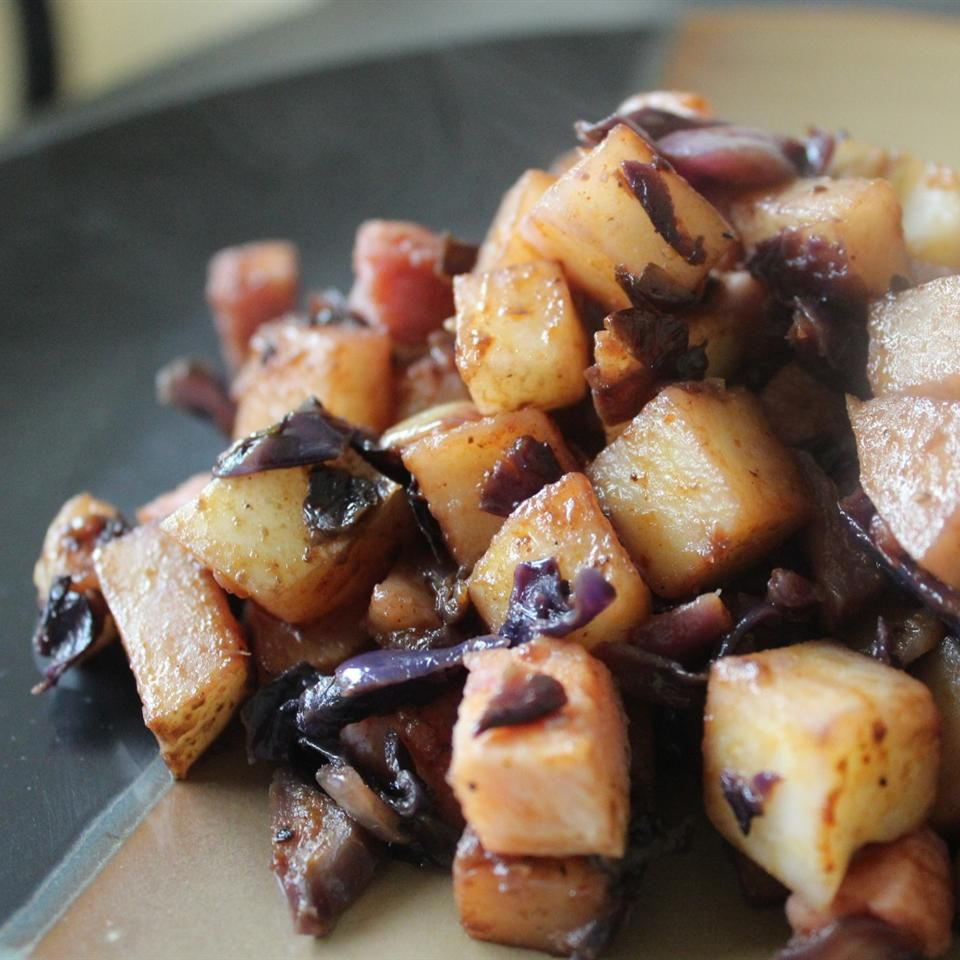


Recipe Name:
Skillet Ham, Cabbage and Potatoes

Recipe Name:
In a large skillet over medium heat, saute onions in the margarine.
 When tender add cabbage and stir.
 Pour water over, cover and simmer gently on medium low for ten minutes.
Add potatoes and mix.
 Cover again and allow to simmer for ten more minutes.
 Additional water may be needed.
 Sprinkle seasoning salt and paprika over cabbage and potatoes.
 Allow to simmer covered for an additional 5 to 10 minutes until cabbage is soft and potatoes are nearly cooked.
 Mix ham in and finish cooking until ham is hot and potatoes are done.


Recipe Name:
2 tablespoons margarine 
1 onion, chopped 
1 small head cabbage, coarsely chopped 
1/4 cup water 
3 large potatoes, scrubbed and sliced 
1 dash seasoning salt 
1 dash paprika 
2 cups cubed cooked ham 


Recipe Name:
80.73

Recipe Name:
3.14

Recipe Name:
11.05


Recommendation Number 2
------------------------------------------------------------------------------------------------------

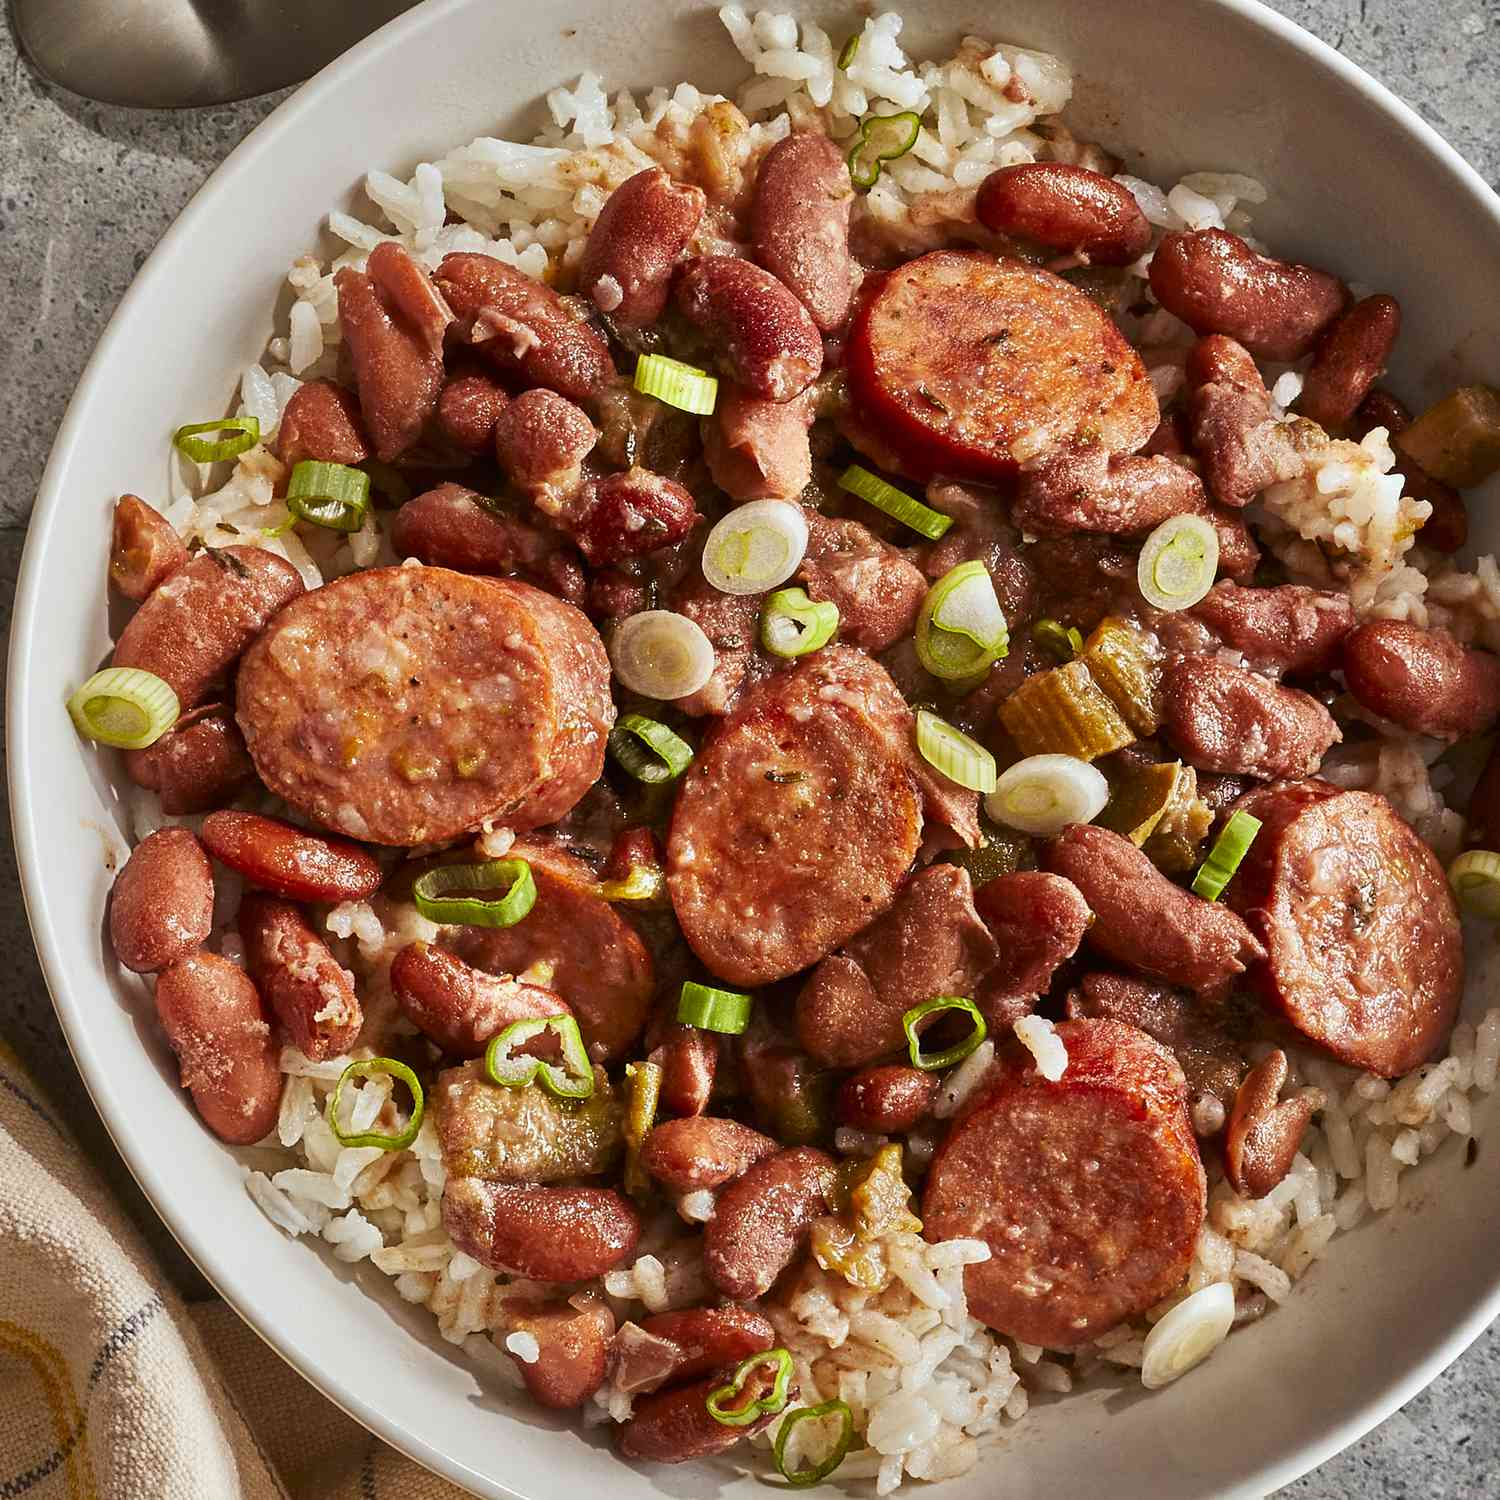


Recipe Name:
Easy Red Beans and Rice

Recipe Name:
In a saucepan, bring water to a boil.
 Add rice and stir.
 Reduce heat, cover and simmer for 20 minutes.
In a large skillet over low heat, cook sausage for 5 minutes.
 Stir in onion, green pepper and garlic, saute until tender.
 Pour in beans and tomatoes with juice.
 Season with oregano, salt and pepper.
 Simmer uncovered for 20 minutes.
 Serve over rice.


Recipe Name:
2 cups water 
1 cup uncooked rice 
nan   
1 (16 ounce) package turkey kielbasa, cut diagonally into 1/4 inch slices 
1 onion, chopped 
1 green bell pepper, chopped 
1 clove chopped garlic 
2 (15 ounce) cans canned kidney beans, drained 
1 (16 ounce) can whole peeled tomatoes, chopped 
1/2 teaspoon dried oregano 
nan salt to taste 
1/2 teaspoon pepper 


Recipe Name:
87.95

Recipe Name:
4.96

Recipe Name:
12.9


Recommendation Number 3
---------------------------------------------------------------------------------------------------------------------------------------

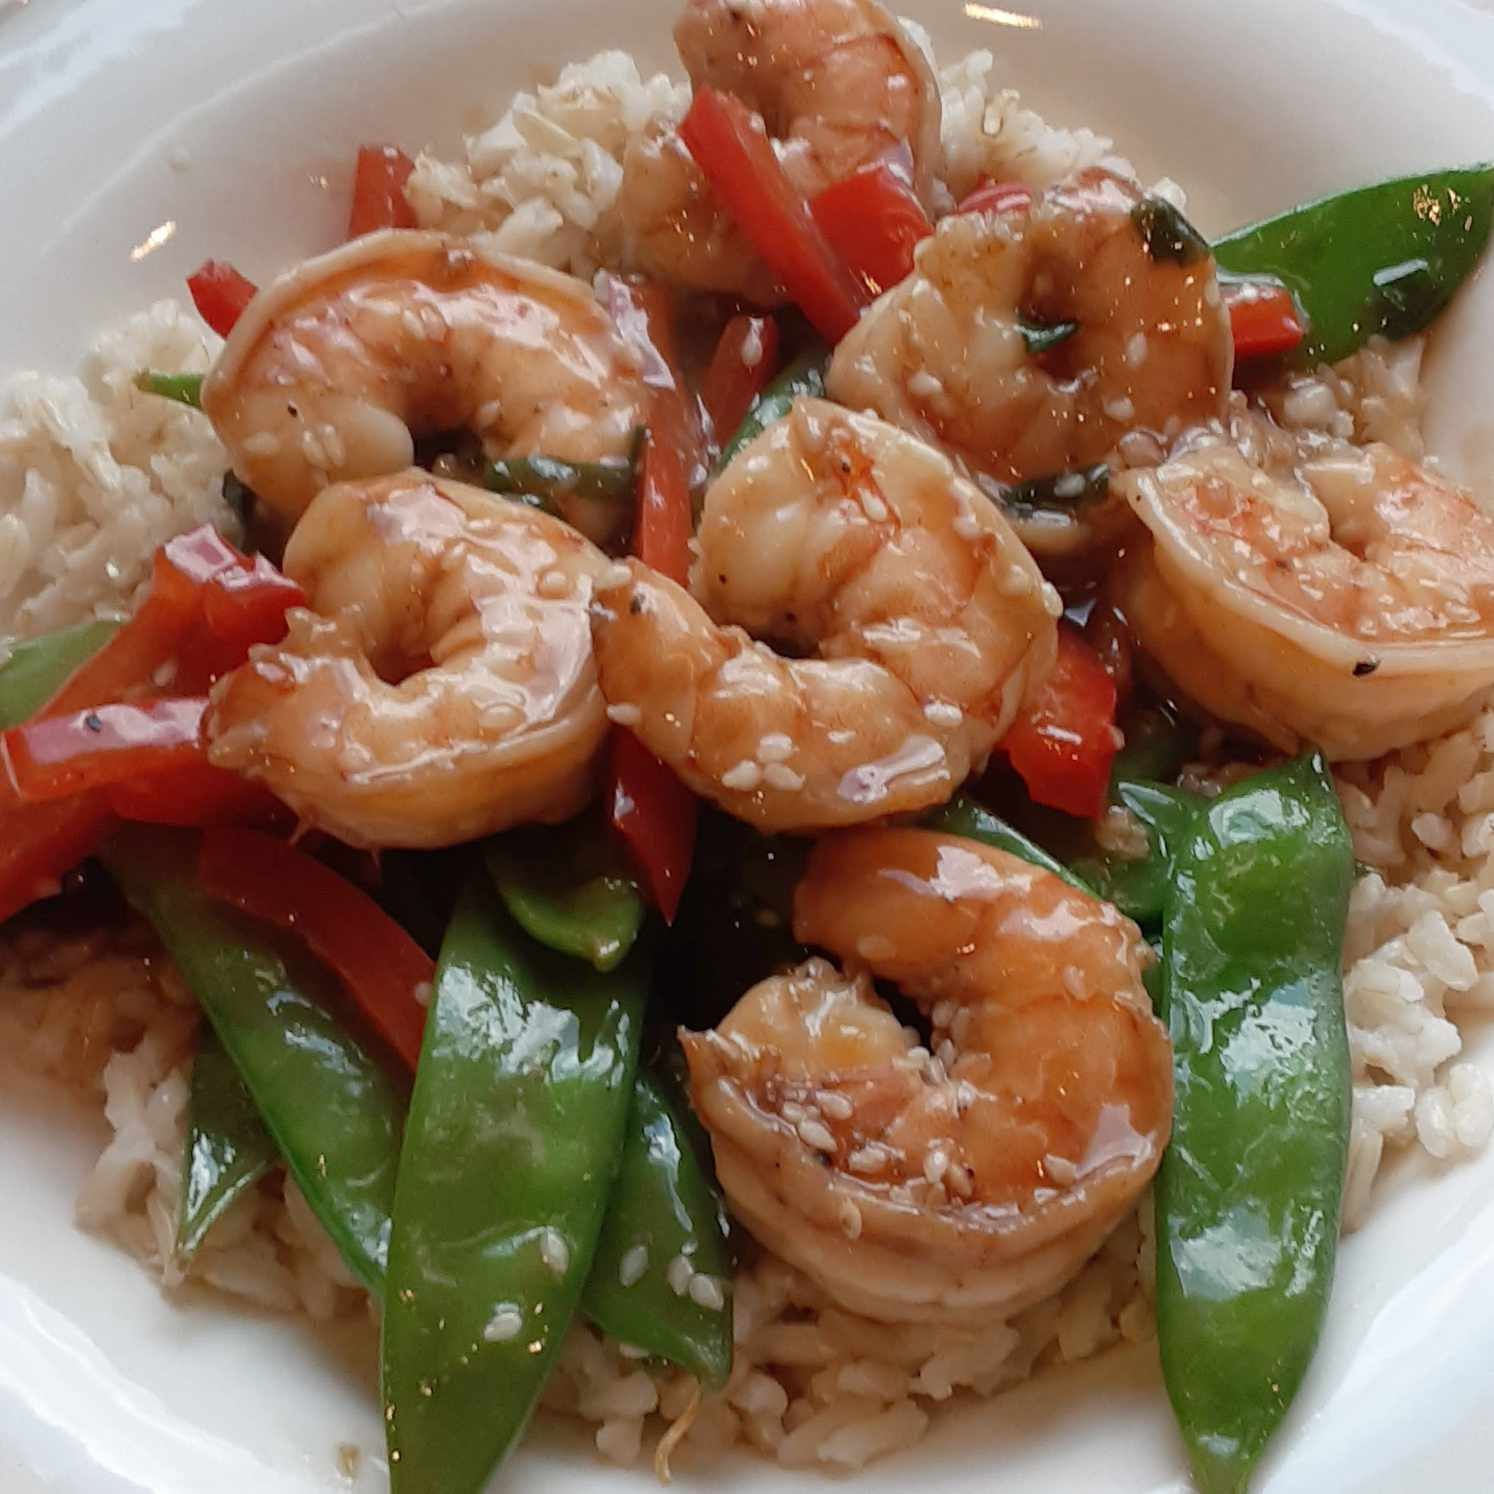


Recipe Name:
Sesame Shrimp Stir-Fry

Recipe Name:
In a medium saucepan, bring salted water to a boil.
 Add rice, reduce heat, cover and simmer for 20 minutes.
While rice is simmering, combine shrimp, ginger, cayenne pepper, garlic, sesame seeds and black pepper in a large plastic food storage bag.
 Allow to marinate in the refrigerator.
Heat sesame oil in a large wok or skillet.
 Add red bell pepper and green onions, saute 3 to 4 minutes to soften slightly Add teriyaki sauce.
 Add peas and shrimp with seasoning, saute 4 minutes or until shrimp are opaque.
Stir cornstarch into chicken broth and add to wok, cook, stirring until mixture boils.
 Sprinkle with salt.
 Spoon shrimp mixture over rice.


Recipe Name:
2 cups water 
1 cup uncooked white rice 
1 pound medium shrimp, peeled and deveined 
1/4 teaspoon ground ginger 
1/4 teaspoon cayenne pepper 
1 clove garlic, minced 
1 tablespoon sesame seeds 
1/4 teaspoon ground black pepper 
2 tablespoons sesame oil 
1 red bell pepper, sliced in

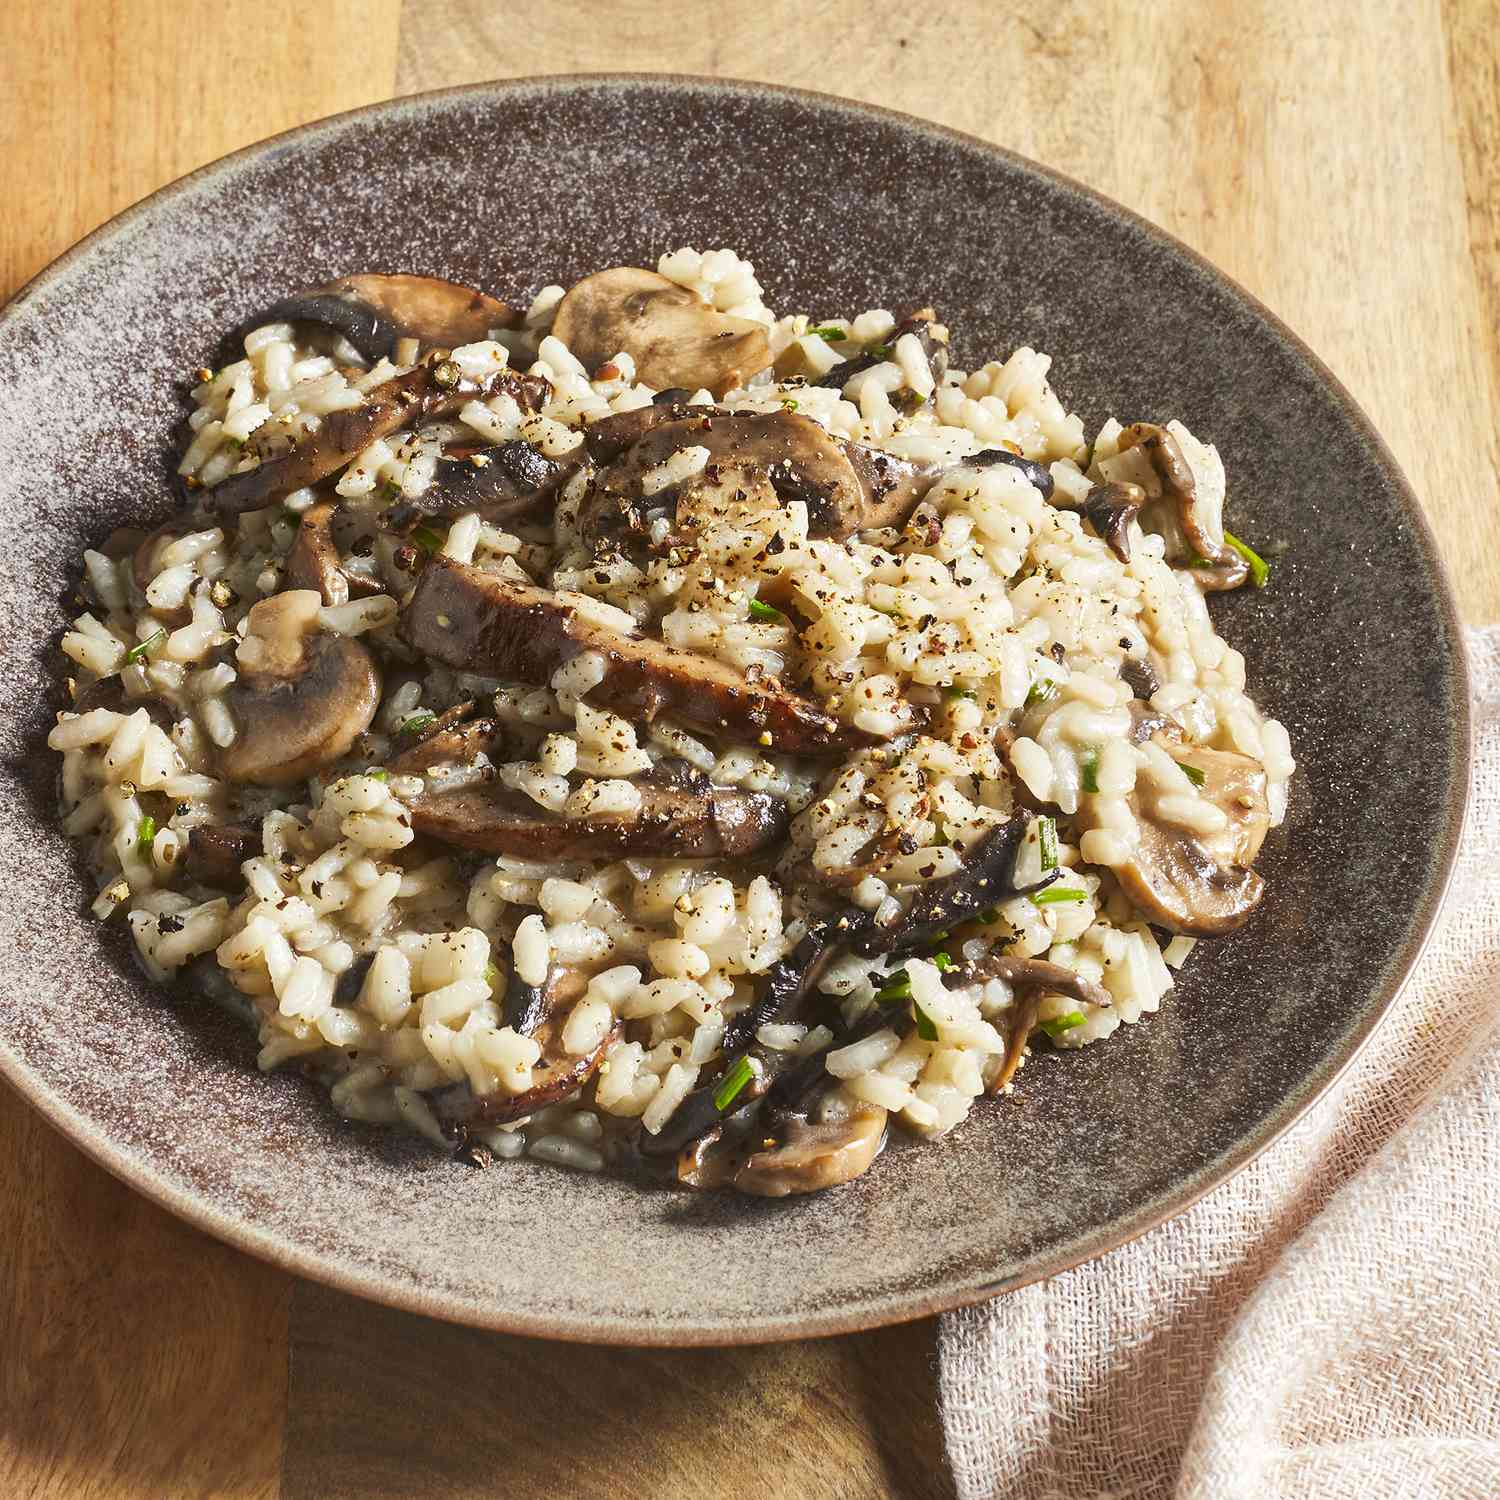


Recipe Name:
Gourmet Mushroom Risotto

Recipe Name:
In a saucepan, warm the broth over low heat.
Warm 2 tablespoons olive oil in a large saucepan over medium-high heat.
 Stir in the mushrooms, and cook until soft, about 3 minutes.
 Remove mushrooms and their liquid, and set aside.
Add 1 tablespoon olive oil to skillet, and stir in the shallots.
 Cook 1 minute.
 Add rice, stirring to coat with oil, about 2 minutes.
 When the rice has taken on a pale, golden color, pour in wine, stirring constantly until the wine is fully absorbed.
 Add 1/2 cup broth to the rice, and stir until the broth is absorbed.
 Continue adding broth 1/2 cup at a time, stirring continuously, until the liquid is absorbed and the rice is al dente, about 15 to 20 minutes.
Remove from heat, and stir in mushrooms with their liquid, butter, chives, and parmesan.
 Season with salt and pepper to taste.


Recipe Name:
6 cups chicken broth, divided 
3 tablespoons olive oil, divided 
1 pound portobello mushrooms, thinly slic

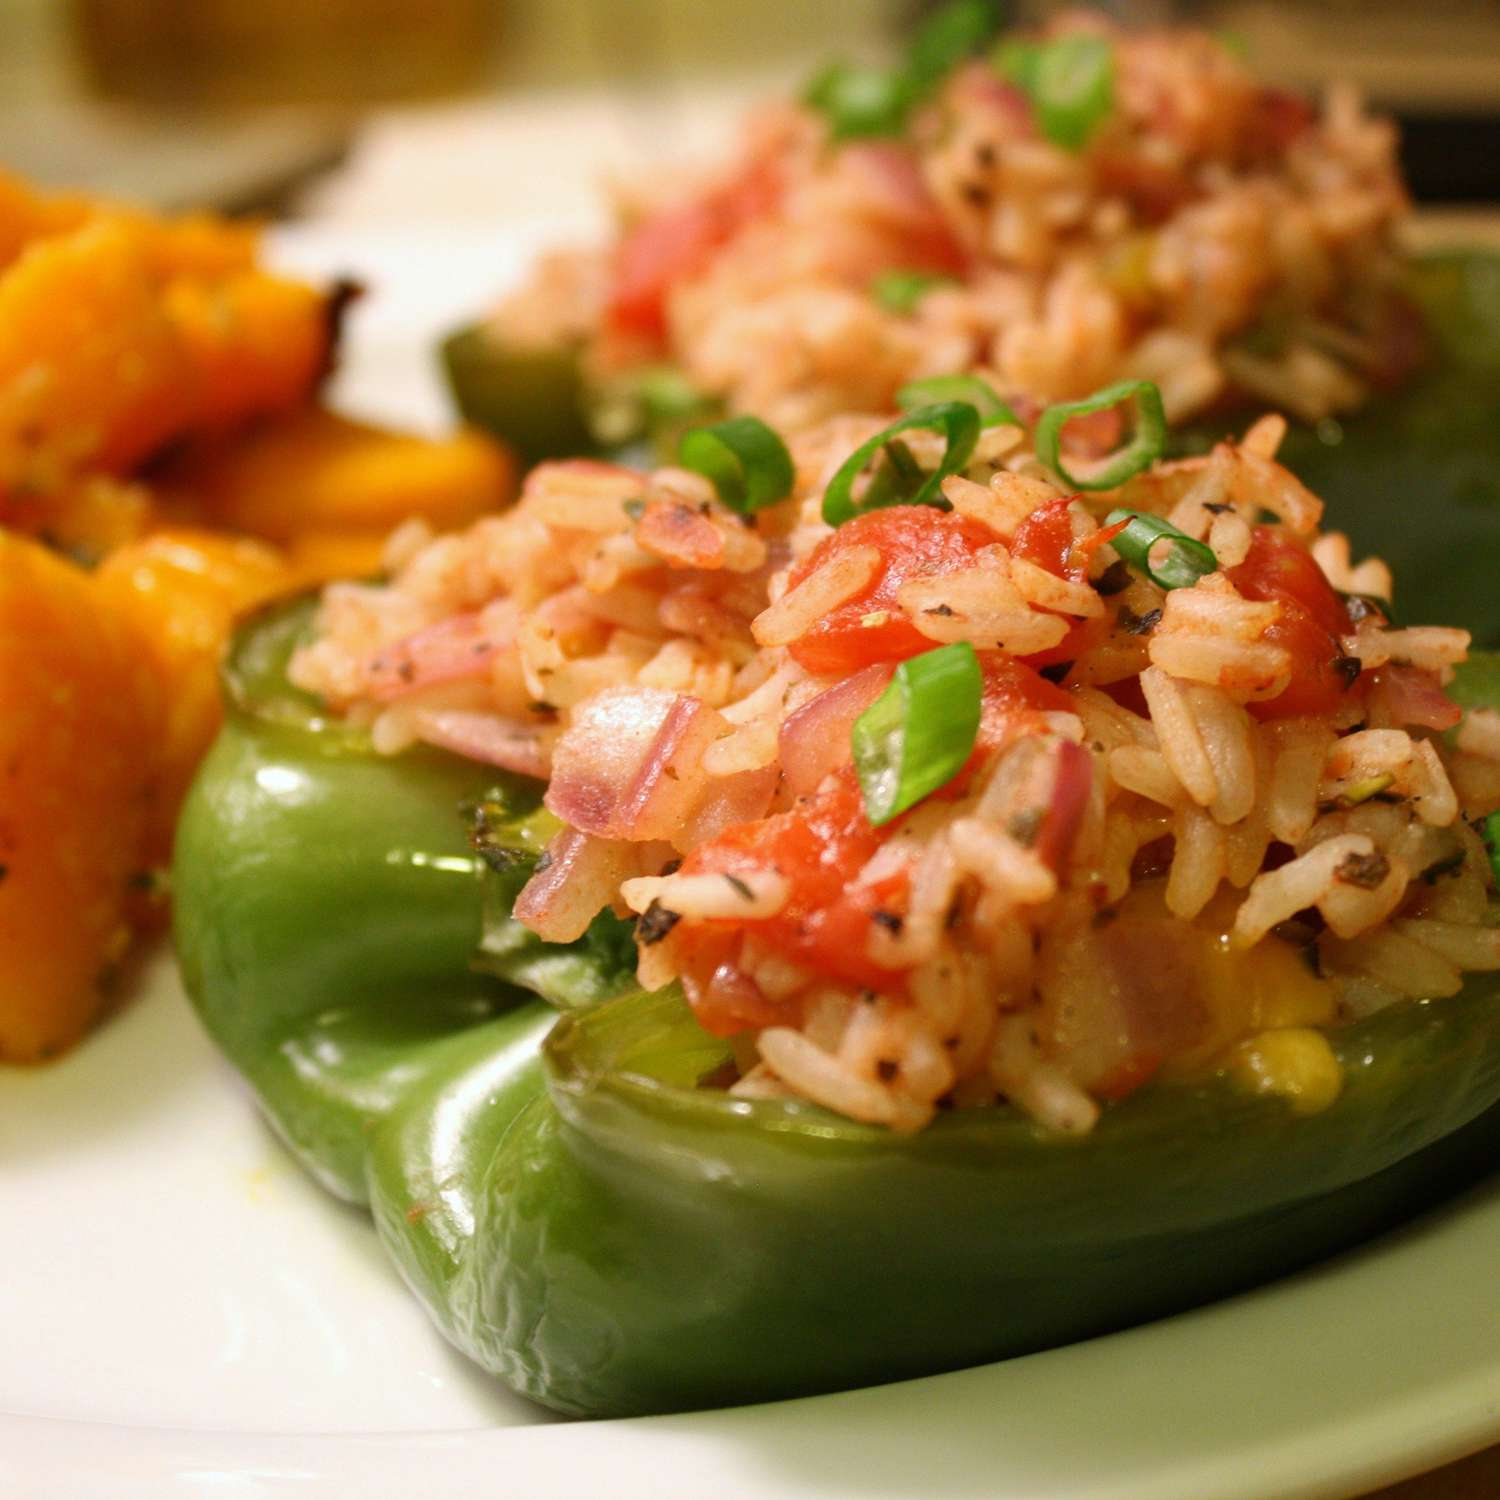


Recipe Name:
Stuffed Peppers My Way

Recipe Name:
Preheat oven to 400 degrees F (200 degrees C).
 Lightly grease a baking sheet.
In a medium saucepan, bring water to a boil.
 Stir in the rice.
 Reduce heat, cover, and simmer for 20 minutes.
 Remove from heat, and set aside.
Place the peppers cut-side down on the prepared baking sheet.
 Roast 25 to 30 minutes in the preheated oven, or until tender and skin starts to brown.
While the peppers are roasting, heat oil in a medium skillet over medium-high heat.
 Cook the onions, basil, Italian seasoning, salt, and pepper in oil for 2 to 3 minutes.
 Stir in the tomato, and cook for 5 minutes.
 Spoon in the cooked rice, and stir until heated through.
 Remove from heat, mix in the feta cheese, and spoon the mixture into the pepper halves.
Return to the oven for 5 minutes.
 Serve immediately.


Recipe Name:
1 cup water 
1/2 cup uncooked Arborio rice 
2 green bell peppers, halved and seeded 
1 tablespoon olive oil 
2 green onions, thinly sliced 


In [259]:
def visualizeRecommendation(dataframe):    
    
    count = 0

    colNames = ['Recipe Name', 'Cooking Directions', 'Ingredients', 'Calories per 100g', 'Proteins per 100g', 'Carbohydrates per 100g']

    out=sys.stdout

    print()
    print('Welcome to our recommendation system that can guarantee to give you the best meals based on your fitness goals and taste preferences.')
    priorityPrint(preferenceDiet, fitnessgoals_dict)

    for index, row, in dataframe.iterrows():
        id = dataframe.loc[index, 'Recipe ID']
        file = 'images/'+str(id)+'.jpg'
        count += 1
        col_count = 0
        out.write('\n')
        out.write('Recommendation Number ' + str(count))
        out.write('\n')
        out.write('---------------------------------------------------------------------------------------------------------------------------------------------------')
        display(Image(filename=file, width = 300, height = 200))
        for i in row[1:]:
            print()
            out.write(colNames[col_count] + ':')
            out.write('\n')
            out.write(str(i))
            out.write('\n')
        out.write('\n')

top_rec = showDF.head(5)
visualizeRecommendation(top_rec)